In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sage.plot.plot3d.parametric_surface import ParametricSurface
import plotly.graph_objects as go
import plotly.express as px
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve

In [2]:
def population_dynamics_model(t, z, T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                               B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                               D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                               N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Temperature and rainfall functions
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Larval development duration
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Daily mosquito survival rate
    def p(Temp):
        return np.exp(-1 / (A * Temp**2 + B * Temp + C))
    
    # Larval survival probability dependent on temperature and rainfall
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4 * p_ML / R_L**2) * Rain * (max(1e-5, R_L - Rain))
    
    def p_LRT(Rain, Temp):
        return p_LR(Rain) * p_LT(Temp)
    
    # Egg and pupa survival probability dependent on rainfall 
    def p_ER(Rain):
        return (4 * p_ME / R_L**2) * Rain * (max(1e-5, R_L - Rain))
    
    # Pupa survival probability dependent on rainfall 
    def p_PR(Rain):
        return (4 * p_MP / R_L**2) * Rain * (max(1e-5, R_L - Rain))

    # Sporogonic cycle duration
    def tau_M(Temp):
        return DD / (max(1e-5, Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Exposed-to-infected rate (1/Sporogonic cycle duration)
    def b3(tau_M, Temp):
        return 1 / tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Defining the mosquito survival function
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Mosquito mortality rate
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calculate biting rate and transmission probability
    def a(Temp):
        return max(1e-5, (Temp - T_prime) / D1)
    
    a_curr = a(T_curr)
    
    def b(Rain, Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain, Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = mu_H * N - a_curr * k * b2 * (I_M / N) * S_H - mu_H * S_H
    dIhdt = a_curr * k * b2 * (I_M / N) * S_H - gamma * I_H - mu_H * I_H
    dRhdt = gamma * I_H - mu_H * R_H
    
    dSmdt = b_curr - a_curr * k * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * k * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
def R0_sir(a, k, b2, gamma, mu_H):
    return abs((a * k * b2) / (gamma + mu_H))
    
#R0_sir_curr = R0_sir(a_curr, b2, gamma)
    
def R0_sei(a, k, b1, b3, l, mu):
    return abs((a * k * b1 * b3) / ((b3 + l) * mu + mu** 2))
    
#R0_sei_curr = R0_sei(a_curr, b1, b3_curr, l_curr, mu_curr)
    
def R0_full(a, k, b1, b2, b3, gamma, l, mu, mu_H):
    return abs(((a**2 * b1 * b2 * b3 * k**2) / (mu*(gamma + mu_H)*(b3 + l + mu)))**(1/2))
    
#R0_curr = R0(a_curr, b1, b2, b3_curr, gamma, l_curr, mu_curr)

In [4]:
def calculate_initial_values(R_L, T_prime, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T0 - T_prime)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    initial_R0_sir = R0_sir(a0, k, b2, gamma, mu_H)
    initial_R0_sei = R0_sei(a0, k, b1, b30, l0, mu0)
    initial_R0_full = R0_full(a0, k, b1, b2, b30, gamma, l0, mu0, mu_H)
    
    return initial_R0_sir, initial_R0_sei, initial_R0_full

In [5]:
T_prime=25.6

T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04

A=12.5
B=15
C=-48.78

mu_H=0.00007
k=1

b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma=1/120
R_L=450
N=7717
M=300000  #0

E_M0=1
I_M0=0 # None
I_H0=1
R_H0=0

if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0 - R_H0
S_M0 = M - E_M0 - I_M0

In [6]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

In [7]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k)

In [8]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.258077185614824 
R0 (SEI) = 0.9002047882569278
R0 (Full) = 0.4819982554225031


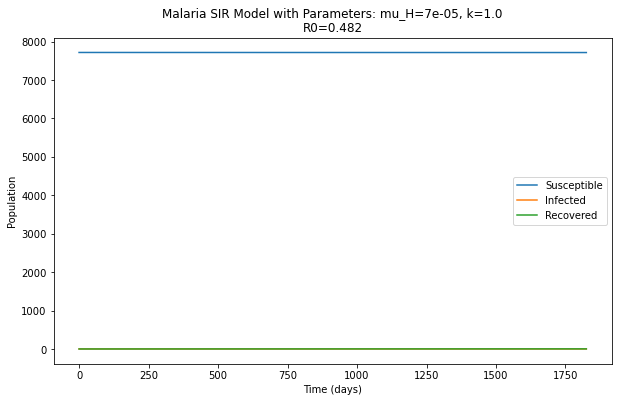

In [9]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

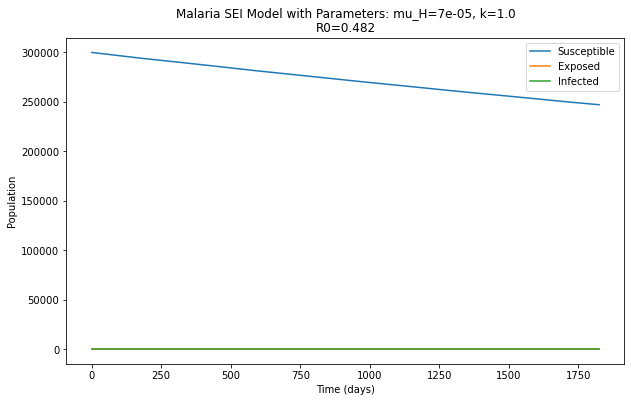

In [10]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

In [11]:
k=1.5

In [12]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

In [13]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k)

In [14]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.387115778422236 
R0 (SEI) = 1.3503071823853918
R0 (Full) = 0.7229973831337546


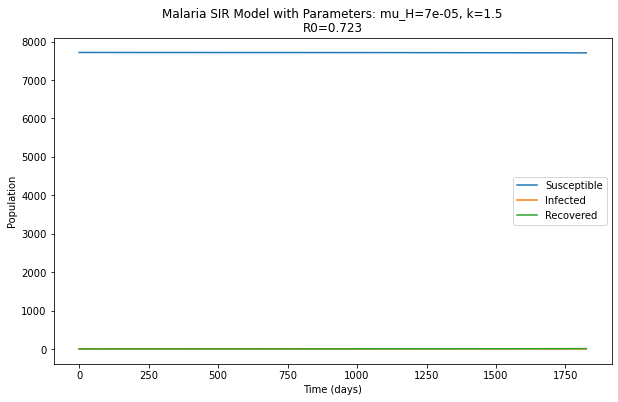

In [15]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

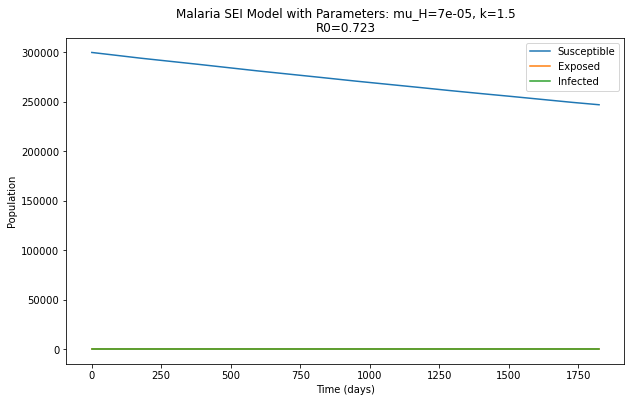

In [16]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

In [17]:
k=2

In [18]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

In [19]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k)

In [20]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.516154371229648 
R0 (SEI) = 1.8004095765138557
R0 (Full) = 0.9639965108450061


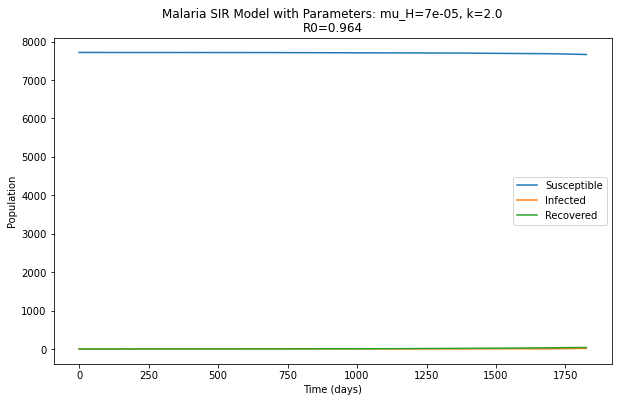

In [21]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

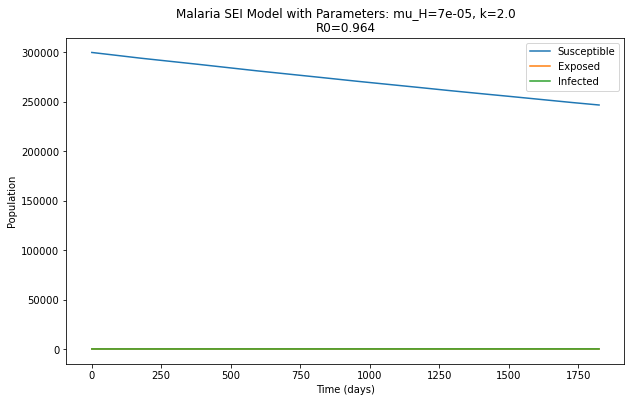

In [22]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

In [23]:
k=2.5

In [24]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

In [25]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k)

In [26]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.6451929640370601 
R0 (SEI) = 2.25051197064232
R0 (Full) = 1.2049956385562577


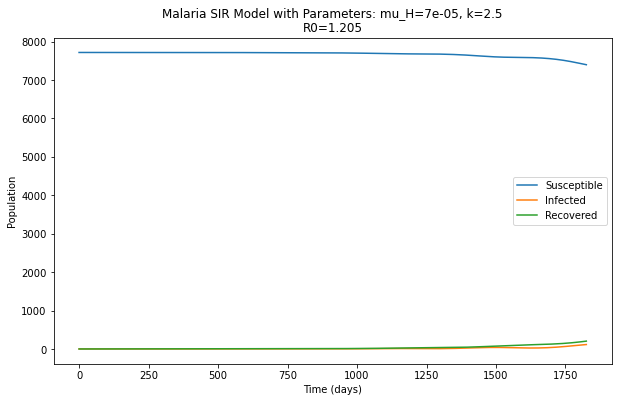

In [27]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

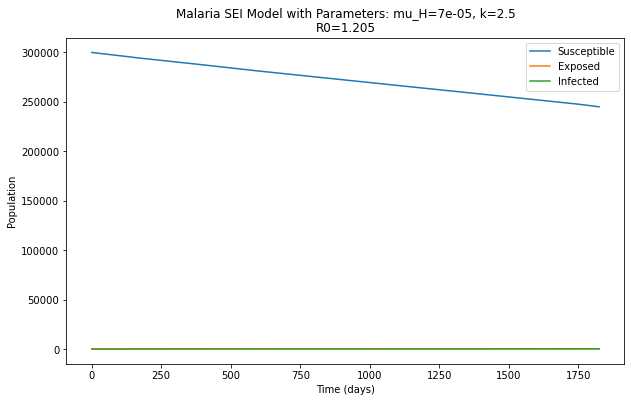

In [28]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

In [29]:
k=5

In [30]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

In [31]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k)

In [32]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 1.2903859280741201 
R0 (SEI) = 4.50102394128464
R0 (Full) = 2.4099912771125154


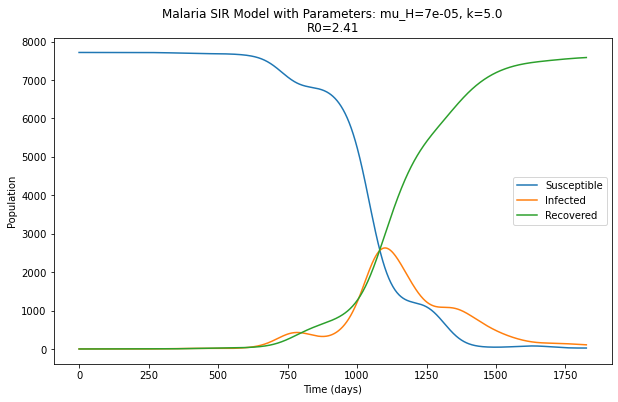

In [33]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

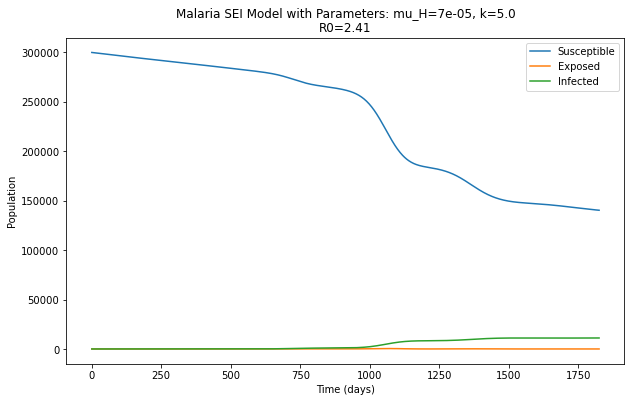

In [34]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

In [35]:
k=10

In [36]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

In [37]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k)

In [38]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 2.5807718561482402 
R0 (SEI) = 9.00204788256928
R0 (Full) = 4.819982554225031


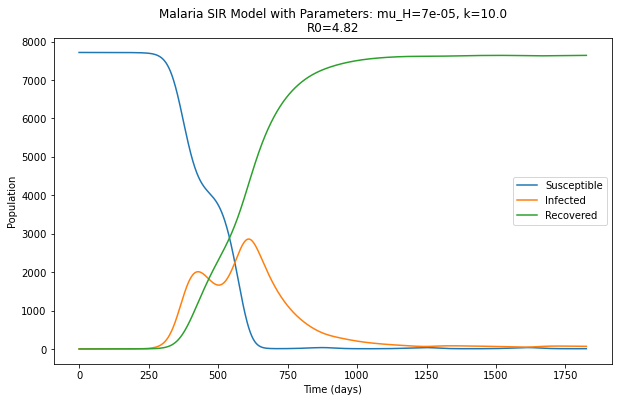

In [39]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

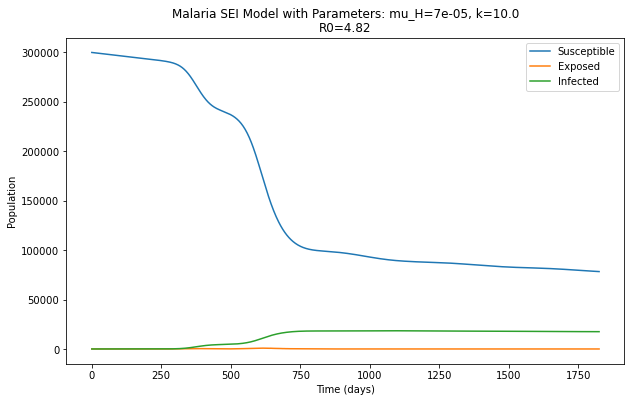

In [40]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, k={round(k, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

#### Calculating $\mathcal{R}_0$ in function of $k$:

In [41]:
def equation_to_solve(k):
    initial_R0_full = calculate_initial_values(
        R_L, T_prime, Tmin, DD, D1, T1, T2,
        omega1, phi1, R1, R2, omega2, phi2,
        p_ML, p_ME, p_MP, c1, c2, A, B, C,
        b1, b2, gamma, mu_H, k)[2] ##index of R0_full calculate_initial_values
    return initial_R0_full -1

# Use fsolve to find the root (solution)
initial_guess = 0.5  # Choose an initial guess for k
k_solution = fsolve(equation_to_solve, initial_guess)

print(f"The value of k that approximates R0 to 1 is {k_solution[0]}")

The value of k that approximates R0 to 1 is 2.0746963059512207


In [42]:
k_values = np.linspace(0, 10, 100) 

R0_full_values = []

for k_val in k_values:
    initial_R0_sir, initial_R0_sei, R0_full_val = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k=k_val)
    R0_full_values.append(R0_full_val)

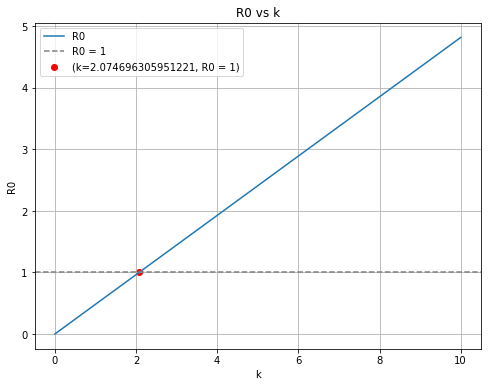

In [43]:
k_value_at_1 = 2.0746963059512207
R0_value_at_1 = 1

plt.figure(figsize=(8, 6))

plt.plot(k_values, R0_full_values, label='R0')
plt.scatter([k_value_at_1], [R0_value_at_1], color='red', label=f'(k={k_value_at_1}, R0 = {R0_value_at_1})')
plt.axhline(y=1, color='gray', linestyle='--', label='R0 = 1')
plt.xlabel('k')
plt.ylabel('R0')
plt.title('R0 vs k')
plt.legend()
plt.grid(True)
plt.show()